**前言**：本节内容是 [Datawhale六月组队学习 - 图神经网络- Task4 数据完整存储于内存的数据集类+节点预测与边预测实践](https://github.com/datawhalechina/team-learning-nlp/tree/master/GNN/Markdown%E7%89%88%E6%9C%AC) 的学习笔记，学习周期4天

### 基础准备

In [23]:
import os.path as osp

import torch
from torch.nn import ReLU, Linear
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from torch_geometric.utils import train_test_split_edges, negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GATConv, Sequential, SAGEConv

import matplotlib.pyplot as plt

训练和测试用到的函数

In [2]:
def result(train, test, epoch=501):
    train_loss = []
    train_acc = [];test_acc=[]
    for i in range(1, epoch):
        loss, acc = train()
        train_loss.append(loss)
        train_acc.append(acc)
        if i % 20 == 0:
            print('[Epoch {}/{}] Loss {:.4f}, train acc {:.4f}'.format(i, epoch-1, loss, acc))
            acc = test()
            test_acc.append(acc)
            print('Accuracy: {:.4f}'.format(acc))
        
    return (train_loss, train_acc, test_acc)

### InMemoryDataset基类和实例
```python
class InMemoryDataset(root: Optional[str] = None, transform: Optional[Callable] = None, pre_transform: Optional[Callable] = None, pre_filter: Optional[Callable] = None)
```

In [3]:
import os.path as osp

import torch
from torch_geometric.data import (InMemoryDataset, download_url)
from torch_geometric.io import read_planetoid_data

class PlanetoidPubMed(InMemoryDataset):
    r""" 节点代表文章，边代表引用关系。
   		 训练、验证和测试的划分通过二进制掩码给出。
    参数:
        root (string): 存储数据集的文件夹的路径
        transform (callable, optional): 数据转换函数，每一次获取数据时被调用。
        pre_transform (callable, optional): 数据转换函数，数据保存到文件前被调用。
    """

    url = 'https://github.com/kimiyoung/planetoid/raw/master/data'

    def __init__(self, root, transform=None, pre_transform=None):
        super(PlanetoidPubMed, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
        return osp.join(self.root, 'raw')

    @property
    def processed_dir(self):
        return osp.join(self.root, 'processed')

    @property
    def raw_file_names(self):
        names = ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']
        return ['ind.pubmed.{}'.format(name) for name in names]

    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        for name in self.raw_file_names:
            download_url('{}/{}'.format(self.url, name), self.raw_dir)

    def process(self):
        data = read_planetoid_data(self.raw_dir, 'pubmed')
        data = data if self.pre_transform is None else self.pre_transform(data)
        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self):
        return '{}()'.format(self.name)

In [4]:
dataset = PlanetoidPubMed('dataset/PlanetoidPubMed')
print('num_classes:\t', dataset.num_classes)
print('num_nodes:\t', dataset[0].num_nodes)
print('num_edges:\t', dataset[0].num_edges)
print('num_features:\t', dataset[0].num_features)

num_classes:	 3
num_nodes:	 19717
num_edges:	 88648
num_features:	 500


### 节点预测实践

In [5]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels_list, num_classes):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        hns = [num_features] + hidden_channels_list
        conv_list = []
        for idx in range(len(hidden_channels_list)):
            conv_list.append((GATConv(hns[idx], hns[idx+1]), 'x, edge_index -> x'))
            conv_list.append(ReLU(inplace=True),)

        self.convseq = Sequential('x, edge_index', conv_list)
        self.linear = Linear(hidden_channels_list[-1], num_classes)

    def forward(self, x, edge_index):
        x = self.convseq(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear(x)
        return x

In [9]:
hidden_channels_list = [200, 100]
model = GAT(num_features=dataset[0].num_features,
            hidden_channels_list=hidden_channels_list,
            num_classes=dataset.num_classes)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

data = dataset[0]
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask]
                     )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    pred = out.argmax(dim=1)
    correct = float(pred[data.train_mask].eq(
        data.y[data.train_mask]).sum().item())
    acc = correct / data.train_mask.sum().item()
    optimizer.step()  # Update parameters based on gradients.
    return loss.cpu().detach().data.item(), acc


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[
        data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(
        data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

GAT(
  (convseq): Sequential(
    (0): GATConv(500, 200, heads=1)
    (1): ReLU(inplace=True)
    (2): GATConv(200, 100, heads=1)
    (3): ReLU(inplace=True)
  )
  (linear): Linear(in_features=100, out_features=3, bias=True)
)


In [10]:
%time (train_loss, train_acc, test_acc) = result(train, test)

[Epoch 20/500] Loss 0.0157, train acc 1.0000
Accuracy: 0.7640
[Epoch 40/500] Loss 0.0093, train acc 1.0000
Accuracy: 0.7460
[Epoch 60/500] Loss 0.0177, train acc 1.0000
Accuracy: 0.7620
[Epoch 80/500] Loss 0.0132, train acc 1.0000
Accuracy: 0.7530
[Epoch 100/500] Loss 0.0078, train acc 1.0000
Accuracy: 0.7620
[Epoch 120/500] Loss 0.0115, train acc 1.0000
Accuracy: 0.7520
[Epoch 140/500] Loss 0.0091, train acc 1.0000
Accuracy: 0.7440
[Epoch 160/500] Loss 0.0084, train acc 1.0000
Accuracy: 0.7630
[Epoch 180/500] Loss 0.0036, train acc 1.0000
Accuracy: 0.7200
[Epoch 200/500] Loss 0.0050, train acc 1.0000
Accuracy: 0.7440
[Epoch 220/500] Loss 0.0107, train acc 1.0000
Accuracy: 0.7530
[Epoch 240/500] Loss 0.0054, train acc 1.0000
Accuracy: 0.7520
[Epoch 260/500] Loss 0.0033, train acc 1.0000
Accuracy: 0.7530
[Epoch 280/500] Loss 0.0054, train acc 1.0000
Accuracy: 0.7370
[Epoch 300/500] Loss 0.0042, train acc 1.0000
Accuracy: 0.7490
[Epoch 320/500] Loss 0.0036, train acc 1.0000
Accuracy: 0.7

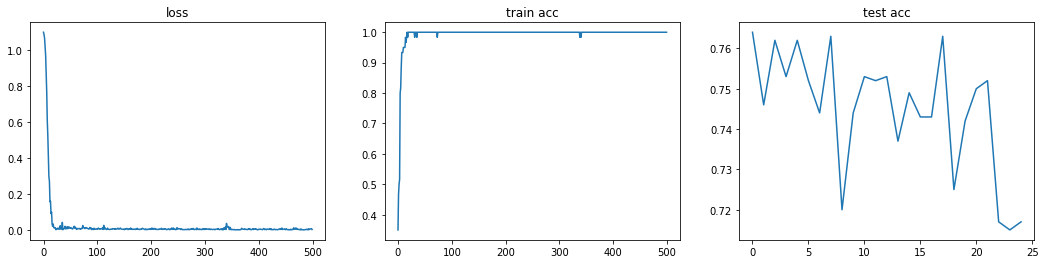

In [11]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(train_loss);plt.title('loss')
plt.subplot(1,3,2);plt.plot(train_acc);plt.title('train acc')
plt.subplot(1,3,3);plt.plot(test_acc);plt.title('test acc')                    
plt.show()

### 边预测实践

取得数据

In [13]:
dataset = Planetoid('dataset/Cora', 'Cora', transform=T.NormalizeFeatures())
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = data.y = None # 不再有用

print(data.edge_index.shape)

data = train_test_split_edges(data) # 自动地采样得到负样本，并将正负样本分成训练集、验证集和测试集三个集合

for key in data.keys:
    print('{}:\t{}'.format(key, getattr(data, key).shape))

torch.Size([2, 10556])
x:	torch.Size([2708, 1433])
val_pos_edge_index:	torch.Size([2, 263])
test_pos_edge_index:	torch.Size([2, 527])
train_pos_edge_index:	torch.Size([2, 8976])
train_neg_adj_mask:	torch.Size([2708, 2708])
val_neg_edge_index:	torch.Size([2, 263])
test_neg_edge_index:	torch.Size([2, 527])


构建网络

In [14]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = GCNConv(in_channels, 128)
        self.conv2 = GCNConv(128, out_channels)

    def encode(self, x, edge_index): # 编码，生成节点表征
        x = self.conv1(x, edge_index)
        x = x.relu()
        return self.conv2(x, edge_index)

    def decode(self, z, pos_edge_index, neg_edge_index): # 解码，为真的几率
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def decode_all(self, z): # inference
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [15]:
def get_link_labels(pos_edge_index, neg_edge_index):
    num_links = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(num_links, dtype=torch.float)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [13]:
# 定义训练函数
def train(data, model, optimizer):
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1))

    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index).to(data.x.device)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss

In [6]:
# 定义测试函数
@torch.no_grad()
def test(data, model):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    results = []
    for prefix in ['val', 'test']:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)
        results.append(roc_auc_score(link_labels.cpu(), link_probs.cpu()))
    return results

In [29]:
def main(epoch=101):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    dataset = 'Cora'
    path = 'dataset/Cora'
    dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
    data = dataset[0]
    ground_truth_edge_index = data.edge_index.to(device)
    data.train_mask = data.val_mask = data.test_mask = data.y = None
    data = train_test_split_edges(data)
    data = data.to(device)

    model = Net(dataset.num_features, 64).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

    best_val_auc = test_auc = 0; train_loss = []; val_list = []; tmp_test_list=[]; test_list=[]
    for i in range(1, epoch):
        loss = train(data, model, optimizer)
        val_auc, tmp_test_auc = test(data, model)
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            test_auc = tmp_test_auc
        train_loss.append(loss); val_list.append(val_auc)
        tmp_test_list.append(tmp_test_auc); test_list.append(test_auc)
        if i % 20 == 0:
            print(f'[Epoch: {i:03d}/{epoch}], Loss: {loss:.4f}, Val: {val_auc:.4f}, '
                  f'Test: {test_auc:.4f}')
    
    z = model.encode(data.x, data.train_pos_edge_index)
    final_edge_index = model.decode_all(z)
    return train_loss, val_list, tmp_test_list, test_list

if __name__ == "__main__":
    train_loss, val_list, tmp_test_list, test_list = main(epoch=1000)

[Epoch: 020/1000], Loss: 0.6577, Val: 0.7376, Test: 0.7832
[Epoch: 040/1000], Loss: 0.5237, Val: 0.8493, Test: 0.8395
[Epoch: 060/1000], Loss: 0.4745, Val: 0.8997, Test: 0.8943
[Epoch: 080/1000], Loss: 0.4587, Val: 0.9096, Test: 0.9053
[Epoch: 100/1000], Loss: 0.4448, Val: 0.9228, Test: 0.9185
[Epoch: 120/1000], Loss: 0.4344, Val: 0.9301, Test: 0.9263
[Epoch: 140/1000], Loss: 0.4307, Val: 0.9255, Test: 0.9257
[Epoch: 160/1000], Loss: 0.4266, Val: 0.9221, Test: 0.9257
[Epoch: 180/1000], Loss: 0.4181, Val: 0.9247, Test: 0.9257
[Epoch: 200/1000], Loss: 0.4087, Val: 0.9267, Test: 0.9257
[Epoch: 220/1000], Loss: 0.4102, Val: 0.9302, Test: 0.9257
[Epoch: 240/1000], Loss: 0.4135, Val: 0.9318, Test: 0.9266
[Epoch: 260/1000], Loss: 0.4078, Val: 0.9358, Test: 0.9285
[Epoch: 280/1000], Loss: 0.4067, Val: 0.9323, Test: 0.9285
[Epoch: 300/1000], Loss: 0.3999, Val: 0.9368, Test: 0.9274
[Epoch: 320/1000], Loss: 0.4023, Val: 0.9350, Test: 0.9287
[Epoch: 340/1000], Loss: 0.3981, Val: 0.9339, Test: 0.92

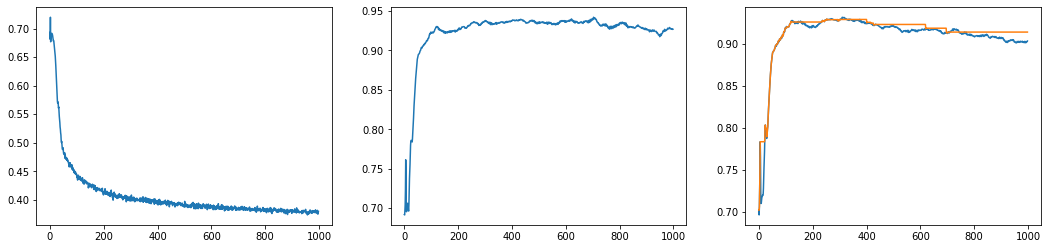

In [31]:
# 简单可视化
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(train_loss)
plt.subplot(1,3,2);plt.plot(val_list)
plt.subplot(1,3,3);plt.plot(tmp_test_list);plt.plot(test_list)
plt.show()

### 作业

#### 实践问题一
&emsp;&emsp;尝试使用PyG中的不同的网络层去代替GCNConv，以及不同的层数和不同的out_channels，来实现节点分类任务。

In [36]:
# 由于不太了解其他的网络层，主要参考了本期学员博客使用的SAGEConv
# 地址：https://www.yuque.com/pretender-xkbwx/vxvg55/gpon5t#64e6bda1

In [29]:
# 网络结构
class SAGE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels_list, num_classes):
        super(SAGE, self).__init__()
        torch.manual_seed(12345)
        hns = [num_features] + hidden_channels_list
        conv_list = []
        for idx in range(len(hidden_channels_list)):
            conv_list.append((SAGEConv(hns[idx], hns[idx+1]), 'x, edge_index -> x'))
            conv_list.append(ReLU(inplace=True), )  # inplace表示是否将得到的值计算得到的值覆盖之前的值

        self.convseq = Sequential('x, edge_index', conv_list)
        self.linear = Linear(hidden_channels_list[-1], num_classes)

    def forward(self, x, edge_index):
        x = self.convseq(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear(x)
        return x

In [33]:
hidden_channels_list = [200, 100, 64]
model = SAGE(num_features=dataset[0].num_features,
            hidden_channels_list=hidden_channels_list,
            num_classes=dataset.num_classes)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

data = dataset[0]
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask]
                     )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    pred = out.argmax(dim=1)
    correct = float(pred[data.train_mask].eq(
        data.y[data.train_mask]).sum().item())
    acc = correct / data.train_mask.sum().item()
    optimizer.step()  # Update parameters based on gradients.
    return loss.cpu().detach().data.item(), acc


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[
        data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(
        data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

SAGE(
  (convseq): Sequential(
    (0): SAGEConv(1433, 200)
    (1): ReLU(inplace=True)
    (2): SAGEConv(200, 100)
    (3): ReLU(inplace=True)
    (4): SAGEConv(100, 64)
    (5): ReLU(inplace=True)
  )
  (linear): Linear(in_features=64, out_features=7, bias=True)
)


In [34]:
%time (train_loss, train_acc, test_acc) = result(train, test, epoch=101)

[Epoch 20/100] Loss 0.2657, train acc 0.9143
Accuracy: 0.7330
[Epoch 40/100] Loss 0.0768, train acc 0.9786
Accuracy: 0.7280
[Epoch 60/100] Loss 0.0343, train acc 1.0000
Accuracy: 0.6940
[Epoch 80/100] Loss 0.0397, train acc 0.9857
Accuracy: 0.7120
[Epoch 100/100] Loss 0.0139, train acc 1.0000
Accuracy: 0.7600
Wall time: 27 s


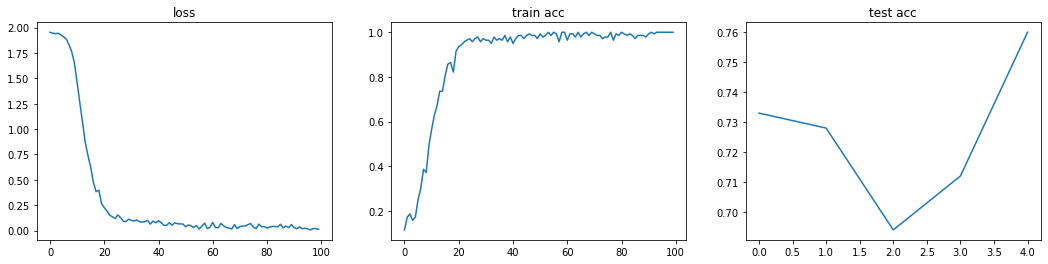

In [37]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(train_loss);plt.title('loss')
plt.subplot(1,3,2);plt.plot(train_acc);plt.title('train acc')
plt.subplot(1,3,3);plt.plot(test_acc);plt.title('test acc')                    
plt.show()

#### 实践问题二
&emsp;&emsp;在边预测任务中，尝试用torch_geometric.nn.Sequential容器构造图神经网络。

In [39]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channnels_list, out_channels):
        super(Net, self).__init__()
        torch.manual_seed(12345)
        hns = [in_channels] + hidden_channnels_list
        conv_list = []
        
        for idx in range(len(hidden_channnels_list)-1):
            conv_list.append((GCNConv(hns[idx], hns[idx+1]), 'x, edge_index -> x'))
            conv_list.append(ReLU(inplace=True), )
        conv_list.append((GCNConv(hns[-2], hns[-1]), 'x, edge_index -> x'))

        self.convseq = Sequential('x, edge_index', conv_list)

    def encode(self, x, edge_index):
        return self.convseq(x, edge_index)

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [43]:
# 定义训练函数
def train(data, model, optimizer):
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1))

    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index).to(data.x.device)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss

In [44]:
# 定义测试函数
@torch.no_grad()
def test(data, model):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    results = []
    for prefix in ['val', 'test']:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)
        results.append(roc_auc_score(link_labels.cpu(), link_probs.cpu()))
    return results

In [45]:
def main(epoch=101):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    dataset = 'Cora'
    path = 'dataset/Cora'
    dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
    data = dataset[0]
    ground_truth_edge_index = data.edge_index.to(device)
    data.train_mask = data.val_mask = data.test_mask = data.y = None
    data = train_test_split_edges(data)
    data = data.to(device)

    model = Net(dataset.num_features, [200, 100], 64).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

    best_val_auc = test_auc = 0; train_loss = []; val_list = []; tmp_test_list=[]; test_list=[]
    for i in range(1, epoch):
        loss = train(data, model, optimizer)
        val_auc, tmp_test_auc = test(data, model)
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            test_auc = tmp_test_auc
        train_loss.append(loss); val_list.append(val_auc)
        tmp_test_list.append(tmp_test_auc); test_list.append(test_auc)
        if i % 20 == 0:
            print(f'[Epoch: {i:03d}/{epoch}], Loss: {loss:.4f}, Val: {val_auc:.4f}, '
                  f'Test: {test_auc:.4f}')
    
    z = model.encode(data.x, data.train_pos_edge_index)
    final_edge_index = model.decode_all(z)
    return train_loss, val_list, tmp_test_list, test_list

if __name__ == "__main__":
    train_loss, val_list, tmp_test_list, test_list = main(epoch=100)

[Epoch: 020/100], Loss: 0.5524, Val: 0.8499, Test: 0.7965
[Epoch: 040/100], Loss: 0.4731, Val: 0.9028, Test: 0.8668
[Epoch: 060/100], Loss: 0.4521, Val: 0.9169, Test: 0.8885
[Epoch: 080/100], Loss: 0.4353, Val: 0.9193, Test: 0.8957


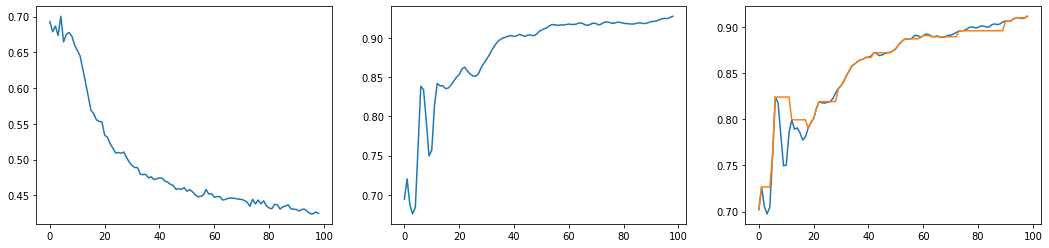

In [46]:
# 简单可视化
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(train_loss)
plt.subplot(1,3,2);plt.plot(val_list)
plt.subplot(1,3,3);plt.plot(tmp_test_list);plt.plot(test_list)
plt.show()

#### 思考问题三
&emsp;&emsp;如下方代码所示，我们以data.train_pos_edge_index为实际参数来进行训练集负样本采样，但这样采样得到的负样本可能包含一些验证集的正样本与测试集的正样本，即可能将真实的正样本标记为负样本，由此会产生冲突。但我们还是这么做，这是为什么？
```python
neg_edge_index = negative_sampling(
    edge_index=data.train_pos_edge_index,
    num_nodes=data.num_nodes,
    num_neg_samples=data.train_pos_edge_index.size(1))
```

negative_sampling源码：
```python
def negative_sampling(edge_index, num_nodes=None, num_neg_samples=None,
                      method="sparse", force_undirected=False):
    r"""Samples random negative edges of a graph given by :attr:`edge_index`.

    Args:
        edge_index (LongTensor): The edge indices.
        num_nodes (int, optional): The number of nodes, *i.e.*
            :obj:`max_val + 1` of :attr:`edge_index`. (default: :obj:`None`)
        num_neg_samples (int, optional): The (approximate) number of negative
            samples to return. If set to :obj:`None`, will try to return a
            negative edge for every positive edge. (default: :obj:`None`)
        method (string, optional): The method to use for negative sampling,
            *i.e.*, :obj:`"sparse"` or :obj:`"dense"`.
            This is a memory/runtime trade-off.
            :obj:`"sparse"` will work on any graph of any size, while
            :obj:`"dense"` can perform faster true-negative checks.
            (default: :obj:`"sparse"`)
        force_undirected (bool, optional): If set to :obj:`True`, sampled
            negative edges will be undirected. (default: :obj:`False`)

    :rtype: LongTensor
    """

    num_nodes = maybe_num_nodes(edge_index, num_nodes)
    num_neg_samples = num_neg_samples or edge_index.size(1)

    # Handle '|V|^2 - |E| < |E|'.
    size = num_nodes * num_nodes
    num_neg_samples = min(num_neg_samples, size - edge_index.size(1))

    row, col = edge_index

    if force_undirected:
        num_neg_samples = num_neg_samples // 2

        # Upper triangle indices: N + ... + 1 = N (N + 1) / 2
        size = (num_nodes * (num_nodes + 1)) // 2

        # Remove edges in the lower triangle matrix.
        mask = row <= col
        row, col = row[mask], col[mask]

        # idx = N * i + j - i * (i+1) / 2
        idx = row * num_nodes + col - row * (row + 1) // 2
    else:
        idx = row * num_nodes + col

    # Percentage of edges to oversample so that we are save to only sample once
    # (in most cases).
    alpha = abs(1 / (1 - 1.1 * (edge_index.size(1) / size)))

    if method == 'dense':
        mask = edge_index.new_ones(size, dtype=torch.bool)
        mask[idx] = False
        mask = mask.view(-1)

        perm = sample(size, int(alpha * num_neg_samples),
                      device=edge_index.device)
        perm = perm[mask[perm]][:num_neg_samples]

    else:
        perm = sample(size, int(alpha * num_neg_samples))
        mask = torch.from_numpy(np.isin(perm, idx.to('cpu'))).to(torch.bool)
        perm = perm[~mask][:num_neg_samples].to(edge_index.device)

    if force_undirected:
        # (-sqrt((2 * N + 1)^2 - 8 * perm) + 2 * N + 1) / 2
        row = torch.floor((-torch.sqrt((2. * num_nodes + 1.)**2 - 8. * perm) +
                           2 * num_nodes + 1) / 2)
        col = perm - row * (2 * num_nodes - row - 1) // 2
        neg_edge_index = torch.stack([row, col], dim=0).long()
        neg_edge_index = to_undirected(neg_edge_index)
    else:
        row = perm // num_nodes
        col = perm % num_nodes
        neg_edge_index = torch.stack([row, col], dim=0).long()

    return neg_edge_index
```

&emsp;&emsp;（其实并不是特别理解为什么会出现题目所述的情况。。）按照题目所述，我认为在‘采样得到的负样本可能包含一些验证集的正样本与测试集的正样本’情况出现的比例比较小时，实际上反而能提高模型的泛化性能。虽然这部分是‘不正确’的负采样，但是可以减轻模型的过拟合现象。如果‘不正确’的比例较小，联想‘随机梯度下降能够生效’这一结论，我觉得少量‘不正确’的数据部分对模型效果的影响也比较有限，但在极端情况下，应该能够有效的缓解模型过拟合。